In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data,color,feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import nltk


nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Data Exploration

In [ ]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = '/content/drive/MyDrive/AiOG/IMDB Dataset.csv'

# Load the dataset into a Pandas DataFrame
dataset = pd.read_csv(csv_file_path)

# Display the first few rows of the dataset to check its structure
print(dataset.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Data Cleaning

In [ ]:
import re

# Function to remove HTML tags from a string
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Apply the function to the 'text' column
dataset['review'] = dataset['review'].apply(remove_html_tags)
# Convert the 'text' column to lowercase
dataset['review'] = dataset['review'].str.lower()
# Function to remove punctuation and special characters from a string
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Apply the function to the 'text' column
dataset['review'] = dataset['review'].apply(remove_punctuation)


Tokenization

In [ ]:
from nltk.tokenize import word_tokenize


# Function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)


# Apply the function to the 'text' column
dataset['tokens'] = dataset['review'].apply(tokenize_text)


from keras.preprocessing.text import Tokenizer


# Create a tokenizer and fit it on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['review'])


# Convert the text tokens to sequences of integers
dataset['sequences'] = tokenizer.texts_to_sequences(dataset['tokens'])


Label enconding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'sentiment' column
dataset['label'] = label_encoder.fit_transform(dataset['sentiment'])

# Display the mapping of original labels to encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)


Label Mapping: {'negative': 0, 'positive': 1}


Length of review

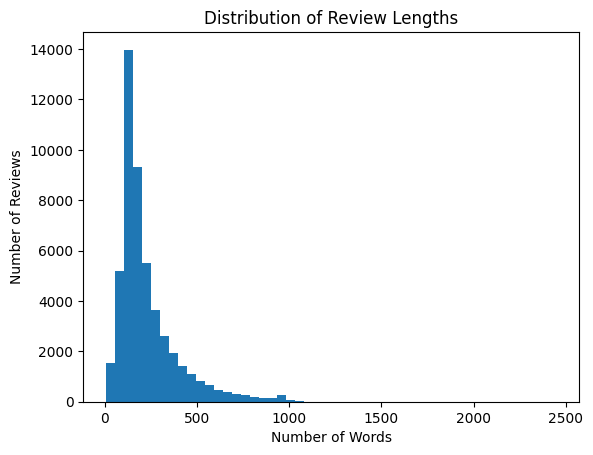

In [ ]:
# Analyze the distribution of review lengths
review_lengths = dataset['review'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.hist(review_lengths, bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.show()


Data Splitting and padding

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.model_selection import train_test_split

# Define the features (X) and labels (y)
X = dataset['review']
y = dataset['label']

# Split the data into training and temporary (validation + test) sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.7, random_state=42)

# Display the sizes of the resulting sets
print("Training set size:", len(X_train_temp))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

# Parameters
vocab_size = 1000
embedding_dim = 50  # can also use pre-trained embeddings like GloVe or Word2Vec


# Set sequence_length to 1000
sequence_length = 1000

# Tokenize the text data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_temp)

# Convert text data to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_temp)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
X_train_pad = pad_sequences(X_train_seq, maxlen=sequence_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=sequence_length, padding='post')


Training set size: 15000
Validation set size: 7000
Test set size: 28000


Data Compiliation and Training with accuracy

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length))
model.add(GRU(128, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


# Train the model
history = model.fit(X_train_pad, y_train_temp, epochs=5, validation_data=(X_val_pad, y_val), batch_size=32)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print("Test Accuracy:", test_accuracy)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 50)          50000     
                                                                 
 gru_4 (GRU)                 (None, 1000, 128)         69120     
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 160593 (627.32 KB)
Trainable params: 160

Confusion Matrix

875/875 [==============================] - 460s 523ms/step


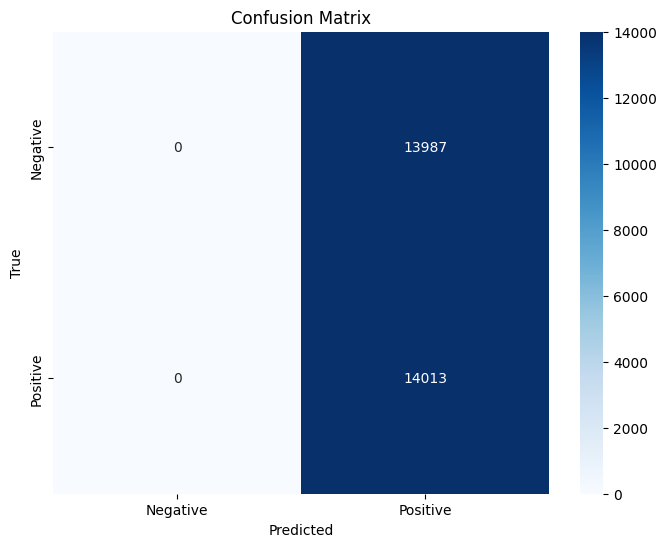

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gettting predictions on the test set
y_pred = model.predict(X_test_pad)

# Converting predictions to binary (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on the test set
test_predictions = model.predict(X_test_pad)
# Convert predictions to binary values (0 or 1)
test_predictions_binary = (test_predictions > 0.3).astype(int)

# Calculate confusion matrix, precision, recall, and F1 score
conf_matrix = confusion_matrix(y_test, test_predictions_binary)
classification_rep = classification_report(y_test, test_predictions_binary)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


875/875 [==============================] - 423s 483ms/step
Confusion Matrix:
[[    0 13987]
 [    0 14013]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13987
           1       0.50      1.00      0.67     14013

    accuracy                           0.50     28000
   macro avg       0.25      0.50      0.33     28000
weighted avg       0.25      0.50      0.33     28000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dataset Citation

@InProceedings{maas-EtAl:2011:ACL-HLT2011, author = {Maas, Andrew L. and Daly, Raymond E. and Pham, Peter T. and Huang, Dan and Ng, Andrew Y. and Potts, Christopher}, title = {Learning Word Vectors for Sentiment Analysis}, booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies}, month = {June}, year = {2011}, address = {Portland, Oregon, USA}, publisher = {Association for Computational Linguistics}, pages = {142--150}, url = {http://www.aclweb.org/anthology/P11-1015} }